In [1]:
import pyarrow.feather as feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
!from keras.models import Sequential
!from keras.layers import Dense
!from keras.optimizers import Adam
!from keras.callbacks import EarlyStopping
!from PyALE import ale

"from" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"from" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"from" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"from" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"from" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"from" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [2]:
#reading the cleaned eda file 
df = pd.read_csv('cleaned_data.csv')

#dropping title column as it is unecessary
df.drop(columns=['title'], inplace=True)


### Dataset generation 
One hote encoding gender

To be able to analyse information concering the movies' genre in a numerical format, a new column for each distinct genre was added to the dataset. The possible values for these columns were 0 (if the movie did not have that genre) and 1 (if the movie had that genre).

In [3]:
#one hot encoding on categorical variable genre 
# Get unique genres
unique_genres = set(','.join(df['genre']).split(', '))

# Create new columns for each genre and initialize them with 0
for genre in unique_genres:
    df[genre] = 0

# Set the value to 1 for the genres that each movie has
for index, row in df.iterrows():
    genres = row['genre'].split(', ')
    for genre in genres:
        df.at[index, genre] = 1

# Fill NaN values with 0 in the genre columns
df.fillna(0, inplace=True)

# Drop the original 'genre' column
df.drop('genre', axis=1, inplace=True)


In [4]:
# Print column names to check whether the creation of the genres columns was successful
print(df.columns)
#apparently there is a column with all genre names combined so this will be dropped by indexing it

# Specify the beginning of the column name you're searching for
column_name_beginning = 'Drama,Unknown,Unknown,Drama,'

# Iterate over column names and find the index of the column with a name that starts with the specified string
genres_combined_column_index = 0
for i, column_name in enumerate(df.columns):
    if column_name.startswith(column_name_beginning):
        print(f"The index of the column with name starting with '{column_name_beginning}' is:", i)
        genres_combined_column_index = i
        break


# Drop the column with the specified index
df = df.drop(df.columns[genres_combined_column_index], axis=1)
# Get all column names
column_names = df.columns

# Print all column names to check if column was dropped
for column in column_names:
    print(column)


Index(['year', 'worldwide_box_office', 'production_budget', 'theatre_count',
       'duration', 'title_length', 'market_potential',
       'Drama,Unknown,Unknown,Drama,Unknown,Drama,Documentary,Comedy,Drama,Drama,Comedy,Drama,Drama,Documentary,Concert/Performance,Drama,Comedy,Action,Documentary,Drama,Horror,Adventure,Adventure,Drama,Drama,Drama,Action,Documentary,Drama,Romantic Comedy,Drama,Comedy,Drama,Documentary,Documentary,Adventure,Romantic Comedy,Documentary,Comedy,Documentary,Drama,Documentary,Horror,Documentary,Comedy,Horror,Thriller/Suspense,Thriller/Suspense,Thriller/Suspense,Drama,Action,Comedy,Thriller/Suspense,Documentary,Adventure,Comedy,Drama,Thriller/Suspense,Documentary,Action,Unknown,Documentary,Drama,Unknown,Comedy,Drama,Unknown,Drama,Comedy,Drama,Comedy,Unknown,Adventure,Comedy,Action,Adventure,Adventure,Comedy,Drama,Drama,Comedy,Drama,Documentary,Action,Romantic Comedy,Adventure,Drama,Drama,Comedy,Drama,Comedy,Action,Adventure,Documentary,Adventure,Drama,Drama,Come

Next the column year was dropped as it would not be a useful predictor for the focal business question.

In [5]:
# Drop the original 'year' column
df.drop('year', axis=1, inplace=True)

Generate train, validation, and test datasets

In [6]:
# include in x all variables except 'worldwide_box_office' 
X = df.drop(columns=['worldwide_box_office']).copy()
y = df[['worldwide_box_office']].copy()

In [7]:
#Splitting dataset into train and test sets
X_train_test, X_test, y_train_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Splitting  training set into training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X_train_test, y_train_test, test_size=0.2, random_state=77)

In [8]:
#Printing sizes of each set
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

#Printing a few rows from each set to inspect the data
print("\nSample rows from Train set:")
print(X_train.head())
print(y_train.head())

print("\nSample rows from Validation set:")
print(X_val.head())
print(y_val.head())

print("\nSample rows from Test set:")
print(X_test.head())
print(y_test.head())

Train set shape: (16922, 21) (16922, 1)
Validation set shape: (4231, 21) (4231, 1)
Test set shape: (5289, 21) (5289, 1)

Sample rows from Train set:
       production_budget  theatre_count  duration  title_length  \
14442          16.300417       1.791759  4.718499      1.945910   
5401           16.811243       2.197225  4.510860      2.564949   
5855           16.811243       2.197225  4.382027      2.564949   
22945          16.811243       2.197225  4.510860      2.833213   
7276           16.811243       2.197225  4.795791      2.079442   

       market_potential  Drama  Unknown  Documentary  Comedy  \
14442         17.909855    1.0      0.0          0.0     0.0   
5401          18.890684    1.0      0.0          0.0     0.0   
5855          18.890684    0.0      0.0          0.0     0.0   
22945         18.890684    1.0      0.0          0.0     0.0   
7276          18.890684    1.0      0.0          0.0     0.0   

       Concert/Performance  ...  Horror  Adventure  Romantic Co

After generating the train, validation and test set , their respective shapes are :
Train set shape: (16922, 21) (16922, 1)
Validation set shape: (4231, 21) (4231, 1)
Test set shape: (5289, 21) (5289, 1)

### Scaling

In [9]:
# Convert all columns in dataset to numerical to prepare them for scaling
df = df.apply(pd.to_numeric, errors='coerce')

In [10]:
# creating standard scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fitting the StandardScaler to df
scaler.fit(df)
# Scaling df used the Standard scalar
scaled_df = pd.DataFrame(scaler.transform(df), columns=df.columns)

### Random forest


Model creation

In [11]:
# Define the Random Forest Regressor model with specified hyperparameters
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=420)

# Train the model using the training data
random_forest_model.fit(X_train, y_train)
# Make predictions on the validation set
predictions = random_forest_model.predict(X_val)

# Calculate and print Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mean_squared_error_val = mean_squared_error(y_val, predictions)
print(f"Mean Squared Error (MSE) on validation set: {mean_squared_error_val:.2f}")
mean_absolute_error_val = mean_absolute_error(y_val, predictions)
print(f"Mean Absolute Error (MAE) on validation set: {mean_absolute_error_val:.2f}")

# Calculate R-squared (coefficient of determination) between actual and predicted values
r_squared = r2_score(y_val, predictions)
print("R-squared:", r_squared)


c:\Users\carol\.conda\envs\Resit\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE) on validation set: 4.83
Mean Absolute Error (MAE) on validation set: 1.66
R-squared: 0.2511355477317395


The MSE on the validation set is 4.83 and indicates the average squared difference between the actual and predicted values. The MAE measuring the average absolute difference between the actual and predicted values is 1.66. The R-squared value is approximately 1.66, indicating that the model explains approximately 25% of the variance in the target variable. A low R-squared value suggests that the model does not fit the data well and thus does not capture a large portion of the variance. Hyperparameter tuning will thus be performed and these scores will be revaluated (see below).

In [12]:
# Using ravel function to convert y_train to a 1-dimensional array 
y_train_flat = np.ravel(y_train)
# Initialize a Random Forest Regressor model with specified hyperparameters
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=420)
# Perform 5-fold cross-validation using negative mean squared error as the scoring metric
cross_val_scores = cross_val_score(random_forest_model, X_train, y_train_flat, cv=5, scoring='neg_mean_squared_error')
cross_val_scores = -cross_val_scores  #Convert negative scores to positive ( sklearn's function returns negative values for loss functions)

# Print the cross-validation scores for each fold and the mean one
print("Cross-validation Scores for each fold:", cross_val_scores)
print("Mean Cross-validation Score:", cross_val_scores.mean())


Cross-validation Scores for each fold: [4.94378764 4.73696723 4.86318653 5.15213882 5.07168025]
Mean Cross-validation Score: 4.953552092720955


The cross validation scores for each fold represent the performance (negative mean squared error) of the model on one fold of the training data. Given that the negative mean squared error is used as metric, higher values indicate better performance. A lower mean cross-validation score (mean of all folds) indicates a better model performance.

Hyperparameter tuning

In [13]:
#defining a large and refined parameter grid for Randomized Search
param_grid = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 20), 
}

# Randomized Search with 5-fold cross-validation
random_forest_model = RandomForestRegressor(random_state=420)
random_search = RandomizedSearchCV(random_forest_model, param_distributions=param_grid, n_iter=10, cv=5,
                                   scoring='neg_mean_squared_error', random_state=420, n_jobs=-1)
random_search.fit(X_train, y_train_flat)

# Print best hyperparameters and score
best_hyperparams_random = random_search.best_params_
best_cv_score_random = -random_search.best_score_
print("Best Hyperparameters found by Randomized Search:", best_hyperparams_random)
print("Best Cross-validation Score found by Randomized Search:", best_cv_score_random)

# Printing results of Randomized Search
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values(by='rank_test_score')  # Sorting by rank for better visibility
desired_columns = ['params', 'mean_test_score', 'rank_test_score']
print("\nParameters Tried in Randomized Search:")
print(results_df[desired_columns])


Best Hyperparameters found by Randomized Search: {'max_depth': 9, 'n_estimators': 341}
Best Cross-validation Score found by Randomized Search: 4.936848759262496

Parameters Tried in Randomized Search:
                                   params  mean_test_score  rank_test_score
7   {'max_depth': 9, 'n_estimators': 341}        -4.936849                1
2   {'max_depth': 8, 'n_estimators': 480}        -4.941758                2
9  {'max_depth': 10, 'n_estimators': 232}        -4.952070                3
1  {'max_depth': 11, 'n_estimators': 113}        -4.978719                4
0   {'max_depth': 6, 'n_estimators': 122}        -4.995898                5
8  {'max_depth': 13, 'n_estimators': 182}        -5.061786                6
3  {'max_depth': 14, 'n_estimators': 204}        -5.118490                7
4  {'max_depth': 15, 'n_estimators': 378}        -5.183389                8
6  {'max_depth': 19, 'n_estimators': 280}        -5.511606                9
5  {'max_depth': 19, 'n_estimators': 20

The cell above prints the hyperparameters that yielded the best cross-validation score during the randomized search. The Randomized Search process identified {'max_depth': 9, 'n_estimators': 341}, as the hyperparameters that resulted in the best performance.


Model evaluation : Random Forest

In [14]:
# Evaluate the Random Forest model after hyperparameter tuning
# Create and train RandomForestRegressor with tuned hyperparameters (on training set)
random_forest_tuned_model = RandomForestRegressor(n_estimators=341, max_depth=9, random_state=420)
random_forest_tuned_model.fit(X_train, y_train)  
predictions_after_tuning = random_forest_tuned_model.predict(X_val)  # Make predictions on the validation set

# Calculate and print MSE and MAE Error for evaluation
mse_after_tuning = mean_squared_error(y_val, predictions_after_tuning) 
print(f"Mean Squared Error (MSE) after tuning: {mse_after_tuning:.2f}")
mae_after_tuning = mean_absolute_error(y_val, predictions_after_tuning)
print(f"Mean Absolute Error (MAE) after tuning: {mae_after_tuning:.2f}")
# Calculate R-squared (coefficient of determination) between actual and predicted values
r_squared = r2_score(y_val, predictions)
print("R-squared after tuning:", r_squared)

c:\Users\carol\.conda\envs\Resit\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE) after tuning: 4.81
Mean Absolute Error (MAE) after tuning: 1.66
R-squared after tuning: 0.2511355477317395


After hyperparameter tuning, there was almost none to none improvement in neither the MSE and nor MAE compared to before tuning . 
The r square coefficient is still around 25% meaning that it remained unvariated afrer hyperparameter tuning.

In [15]:
# Cross-validation after hyperparameter tuning
# Create a RandomForestRegressor with tuned hyperparameters
random_forest_tuned_model = RandomForestRegressor(n_estimators=232, max_depth=10, random_state=420)
# Perform 5-fold cross-validation using negative mean squared error as the scoring metric
cv_scores_tuned = cross_val_score(random_forest_tuned_model, X_train, y_train_flat, cv=5, scoring='neg_mean_squared_error')
cv_scores_tuned = -cv_scores_tuned  # Convert the negative scores to positive 

# Print the cross-validation scores and the mean cross validation score after tuning
print("Cross-validation Scores After Tuning:", cv_scores_tuned)
print("Mean CV Score After Tuning:", cv_scores_tuned.mean())


Cross-validation Scores After Tuning: [4.9375712  4.743371   4.85794228 5.15688355 5.06457951]
Mean CV Score After Tuning: 4.9520695076057075


As in the case of MSE and MAE, also the cross validation scores did not improve. Further analysis and model refinement may be necessary to achieve better predictive accuracy (performance). This could involve exploring additional hyperparameter values, feature engineering, or trying different machine learning algorithms.

In [17]:
#Creating and fitting a RandomForestRegressor with specified hyperparameters (on training set)
rf = RandomForestRegressor(n_estimators=341, max_depth=9, random_state=420)
rf.fit(X_train, y_train)

c:\Users\carol\.conda\envs\Resit\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=9, n_estimators=341, random_state=420)

The model (max_depth=9, n_estimators=341, random_state=420) was fit to the data. 
Next an ANN model was created (see below). The performance of this one will be compared to the one of the random forest model above and the best performing model will be picked to answer the focal business question(s).

### ANN 


Model creation

In [18]:
#import other libraries for neural network
#import tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)

#import keras
import keras
print('keras: %s' % keras.__version__)

#import packages needed from keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from plotnine import ggplot, aes, geom_point



tensorflow: 2.15.0
keras: 2.15.0


In [19]:
print(f"The number of neurons for the input layer must be: {X_train.shape[1]}")

The number of neurons for the input layer must be: 21


In the ANN model the input layer must consist of 21 neurons. Since it is a regression problem, the output layer consits of one neuron where the model predicts a single continuous value (in this case, the worldwide box office). For this reason, the hidden layer was set to 16 neurons as this number is between the number of neurons in the input layer and the number of neurons in the output layer. 
The model was created with the Rectified Linear Unit (ReLU) activation function.

In [20]:
#Creating the ANN model with the activation function relu
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(1)) 

# Configure the Adam optimizer with a custom learning rate
adam = Adam(learning_rate=0.01)
#Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Training the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Check the shape of the training input data (X_train) and of the training output/labels (y_train)
X_train.shape
y_train.shape

#Evaluating the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on validation data: {val_loss}")

# Check the shape of the validation input data (X_validation)
X_val.shape
# Check the shape of the validation output/labels (y_validation)
y_val.shape

#Predicting 'worldwide box office' for validation data
val_predictions = model.predict(X_val)




Epoch 1/10

529/529 [==============================] - 2s 3ms/step - loss: 6.1941 - val_loss: 6.2377
Epoch 2/10
529/529 [==============================] - 1s 2ms/step - loss: 6.0963 - val_loss: 6.0862
Epoch 3/10
529/529 [==============================] - 1s 2ms/step - loss: 6.0426 - val_loss: 6.0972
Epoch 4/10
529/529 [==============================] - 1s 2ms/step - loss: 5.9513 - val_loss: 5.9880
Epoch 5/10
529/529 [==============================] - 2s 3ms/step - loss: 5.8725 - val_loss: 5.8437
Epoch 6/10
529/529 [==============================] - 1s 2ms/step - loss: 5.8141 - val_loss: 5.7479
Epoch 7/10
529/529 [==============================] - 1s 2ms/step - loss: 5.7350 - val_loss: 5.6843
Epoch 8/10
529/529 [==============================] - 1s 2ms/step - loss: 5.6698 - val_loss: 5.6335
Epoch 9/10
529/529 [==============================] - 1s 2ms/step - loss: 5.6299 - val_loss: 5.5790
Epoch 10/10
133/133 [==============================] - 0s 2ms/step - loss: 5.5534
Mean Squared Er

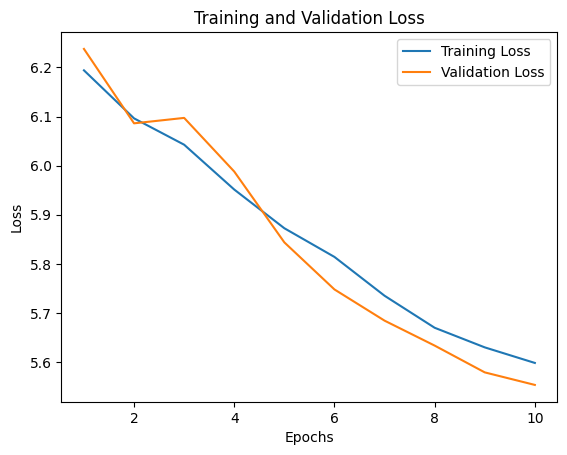

In [21]:
#Loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Creating range of epochs
epochs = range(1, len(training_loss) + 1)

#Plotting training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Altough the validation loss, decreases over epochs it does not do so in an optimal manner. This may indicate that the model does not perform optimally on the new data in the validation set.

To try to improve the model performance the number of neurons in the layers was changed.

In [22]:
#Creating the ANN model with 10 dense layers and Dropout
model = Sequential()
model.add(Dense(192, activation='relu', input_dim=X_train.shape[1]))

for _ in range(10):   #adding 10 hidden layers with 128 neurons each to the neural network model. 
    model.add(Dense(128, activation='relu'))
    
model.add(Dense(1))  #Output layer

#Setting the learning rate for the Adam optimizer
adam_customized = Adam(learning_rate=0.0001)

#Compiling the model with the custom learning rate
model.compile(optimizer=adam_customized, loss='mean_squared_error')

#Defining early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Training the model with early stopping and validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_val, y_val), callbacks=[early_stopping])

#Evaluating the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on validation data: {val_loss}")

#Predicting 'boxoffice' for validation data
val_predictions = model.predict(X_val)

Epoch 1/50
424/424 [==============================] - 6s 6ms/step - loss: 15.4207 - val_loss: 5.9453
Epoch 2/50
424/424 [==============================] - 2s 5ms/step - loss: 5.9221 - val_loss: 5.7181
Epoch 3/50
424/424 [==============================] - 2s 4ms/step - loss: 5.7467 - val_loss: 5.9929
Epoch 4/50
424/424 [==============================] - 2s 4ms/step - loss: 5.6292 - val_loss: 5.5313
Epoch 5/50
424/424 [==============================] - 2s 5ms/step - loss: 5.5840 - val_loss: 5.7247
Epoch 6/50
424/424 [==============================] - 1s 3ms/step - loss: 5.5743 - val_loss: 5.4607
Epoch 7/50
424/424 [==============================] - 2s 4ms/step - loss: 5.6117 - val_loss: 5.6795
Epoch 8/50
424/424 [==============================] - 2s 5ms/step - loss: 5.5442 - val_loss: 5.4338
Epoch 9/50
424/424 [==============================] - 2s 5ms/step - loss: 5.5601 - val_loss: 6.0600
Epoch 10/50
424/424 [==============================] - 2s 4ms/step - loss: 5.5769 - val_loss: 5.385

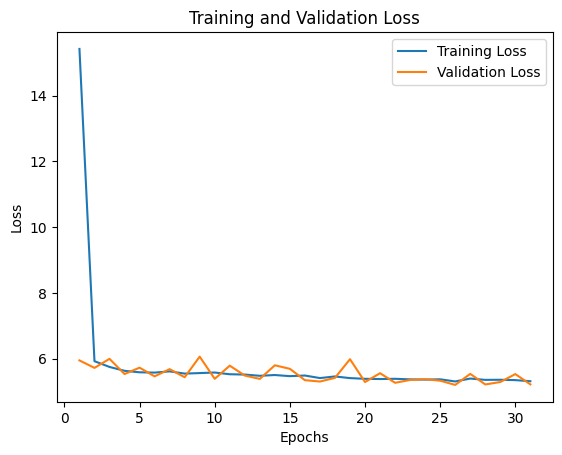

In [23]:
#Loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Creating a range of epochs
epochs = range(1, len(training_loss) + 1)

#Plotting training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training loss is decreasing over epochs indicating that  the model is improving its ability to fit the training data over time. The validation loss is also decreasing over epochs which indicates that the model performs well on the new data in the validation set.

Hyperparameter tuning was performed in the attempt to improve the model performance.

In [24]:
#this code takes around 30 min to run
#Creating the Keras model
def create_model(learning_rate=0.0001, neurons=128, layers=10):
    model = Sequential()
    model.add(Dense(192, activation='relu', input_dim=X_train.shape[1]))

    for _ in range(layers):
        model.add(Dense(neurons, activation='relu'))

    model.add(Dense(1))

    adam_customized = Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam_customized, loss='mean_squared_error')
    return model

#Defininig hyperparameters for the loop 
learning_rates = [0.001, 0.0001, 0.00001]
neurons_list = [64, 128, 256]
layers_list = [6, 8, 10]

best_val_loss = float('inf')
best_params = {}

#Loop through the different hyperparameter combinations
for lr in learning_rates:
    for neurons in neurons_list:
        for layers in layers_list:
            #Create the model
            model = create_model(learning_rate=lr, neurons=neurons, layers=layers)

            #Train the model with early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

            #Evaluate on validation data
            val_loss = model.evaluate(X_val, y_val)

            #Check if current model has the best validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {'learning_rate': lr, 'neurons': neurons, 'layers': layers}

#Print  best parameters and validation loss found
print("Best parameters:", best_params)
print("Best validation loss:", best_val_loss)

133/133 [==============================] - 1s 8ms/step - loss: 5.4250
Best parameters: {'learning_rate': 0.001, 'neurons': 128, 'layers': 10}
Best validation loss: 5.076673984527588


After hyperparameter tuning, it was concluded that the best parameters for ANN were: {'learning_rate': 0.001, 'neurons': 128, 'layers': 10. These will therefore be used to build the final ANN.

In [25]:
#Creating the ANN model 
model = Sequential()
model.add(Dense(192, activation='relu', input_dim=X_train.shape[1]))

for _ in range(10):  #Adding 8 hidden layers with 128 neurons each and dropout
    model.add(Dense(128, activation='relu'))

model.add(Dense(1))  # Output layer

#Setting the learning rate for the Adam optimizer
adam_customized = Adam(learning_rate=0.001)

#Compiling the model with the custom learning rate
model.compile(optimizer=adam_customized, loss='mean_squared_error')

#Defining early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Training the model with early stopping and validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_val, y_val), callbacks=[early_stopping])

#Evaluating the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on validation data: {val_loss}")

#Predicting 'box office' for validation data
val_predictions = model.predict(X_val)

Epoch 1/50
424/424 [==============================] - 6s 6ms/step - loss: 9.1257 - val_loss: 8.8353
Epoch 2/50
424/424 [==============================] - 3s 8ms/step - loss: 5.9257 - val_loss: 6.9009
Epoch 3/50
424/424 [==============================] - 3s 6ms/step - loss: 5.9580 - val_loss: 6.8869
Epoch 4/50
424/424 [==============================] - 3s 7ms/step - loss: 6.0618 - val_loss: 9.1883
Epoch 5/50
424/424 [==============================] - 3s 8ms/step - loss: 5.8876 - val_loss: 5.4876
Epoch 6/50
424/424 [==============================] - 4s 9ms/step - loss: 5.8312 - val_loss: 5.5881
Epoch 7/50
424/424 [==============================] - 4s 9ms/step - loss: 5.8399 - val_loss: 5.4826
Epoch 8/50
424/424 [==============================] - 4s 10ms/step - loss: 5.7925 - val_loss: 6.0342
Epoch 9/50
424/424 [==============================] - 4s 10ms/step - loss: 5.8416 - val_loss: 5.4088
Epoch 10/50
424/424 [==============================] - 4s 10ms/step - loss: 5.6708 - val_loss: 5.4

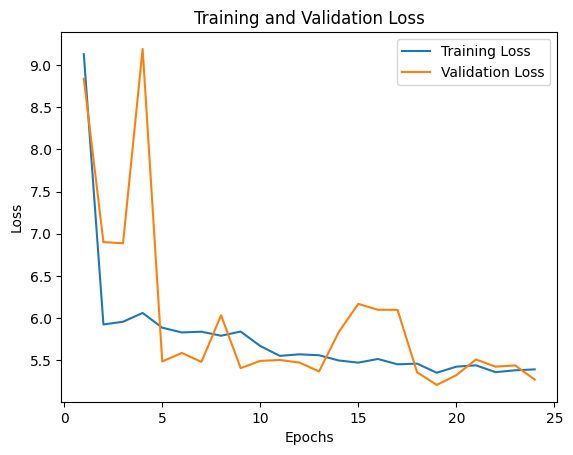

In [26]:
#Accessing loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Creating a range of epochs
epochs = range(1, len(training_loss) + 1)

#Plotting training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

After hyperparameter tuning, we can see that the training error goes down with ephocs, indicating again a good fit with the training data. The validation loss has a more varied distribution as it presents some peaks. However, also this one goes down with ephocs, meaning that after several ephochs the model performs well on new data. 

Model evaluation : ANN

In [27]:
from sklearn.metrics import mean_absolute_error

# Trained sequential model
ann_predictions = model.predict(X_test)

# Calculating metrics
ann_mse = mean_squared_error(y_test, ann_predictions)
ann_r2 = r2_score(y_test, ann_predictions)
ann_mae = mean_absolute_error(y_test, ann_predictions)  # Calculate MAE

# Showing the metrics
print(f"Mean Squared Error (MSE) after tuning: {ann_mse}")
print(f"R-squared (R2) after tuning: {ann_r2}")
print(f"Mean Absolute Error (MAE) after tuning: {ann_mae}")


166/166 [==============================] - 1s 3ms/step
Mean Squared Error (MSE) after tuning: 5.500770462091766
R-squared (R2) after tuning: 0.18009635926222922
Mean Absolute Error (MAE) after tuning: 1.7929220665292918


The ANN model  has a MSE of 5.50 and a MAE of 1.80. The fact that these scores (especially the MAE) are low is good, however, the R squared is only 18%. This means that the variance in the data that can be explained by the model is relatively low and that thus the model performance is not the best.

### Model selection

Random forest vs ANN evaluation

Random Forest =
- Mean Squared Error (MSE) after tuning: 4.81
- Mean Absolute Error (MAE) after tuning: 1.66
- R-squared after tuning: 0.25

Neural Network (ANN) =
- Mean Squared Error (MSE) after tuning: 5.50
- Mean Absolute Erro (MAE) after tuning:  1.79
- R-squared (R2) after tuning: 0.18


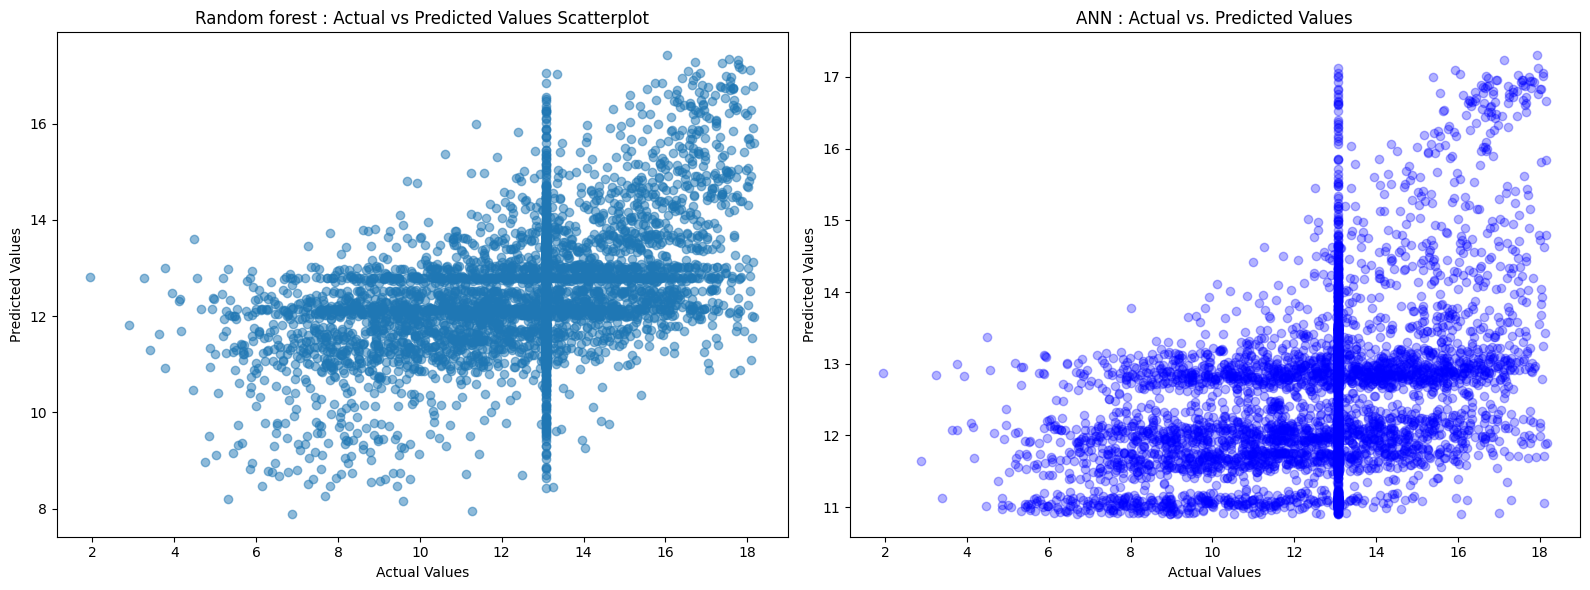

In [28]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

y_pred = rf.predict(X_test)

# Plot Random Forest results
axs[0].scatter(y_test, y_pred, alpha=0.5)
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Random forest : Actual vs Predicted Values Scatterplot')

# Plot ANN results
axs[1].scatter(y_test, ann_predictions, alpha=0.3, color='blue', marker='o')
axs[1].set_xlabel('Actual Values')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('ANN : Actual vs. Predicted Values')

plt.tight_layout()
plt.show()

The scatter plot on the top left ( random forest) displays the actual values along the X-axis and the predicted values along the Y-axis. As it can be observed, higher values somewhat correspond to higher predicted values and the same goes for lower ones. However, datapoints are still sparse, as it is indicated by R squared coefficient. Despite a low MSE (4.55) and MAE (1.58), the R squared coeffient is relatively low (around 25%). This indicates that in the random forest model the variance in the actual values can only be partially explained by the predicted ones.

The ANN model presents a slightly higher MSE (5.51) and MAE (1.78). The R squared coeffient of the neural netowork model is lower than that of the random forest as it is around 18 %. This score is low, indicating that the neural network model does not provide accurate predictions (hence has poor performance). 

Given its lower MSE and MAE and higher r squared, the Random forest model was selected as the best performing model and thus used in the explainability section to answer the research questions (see below). 

### Explainability of best performing model (Random forest)

In [29]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Text(0.5, 0, 'Score')

Text(0, 0.5, 'Features')

Text(0.5, 1.0, 'Feature Importance Score')

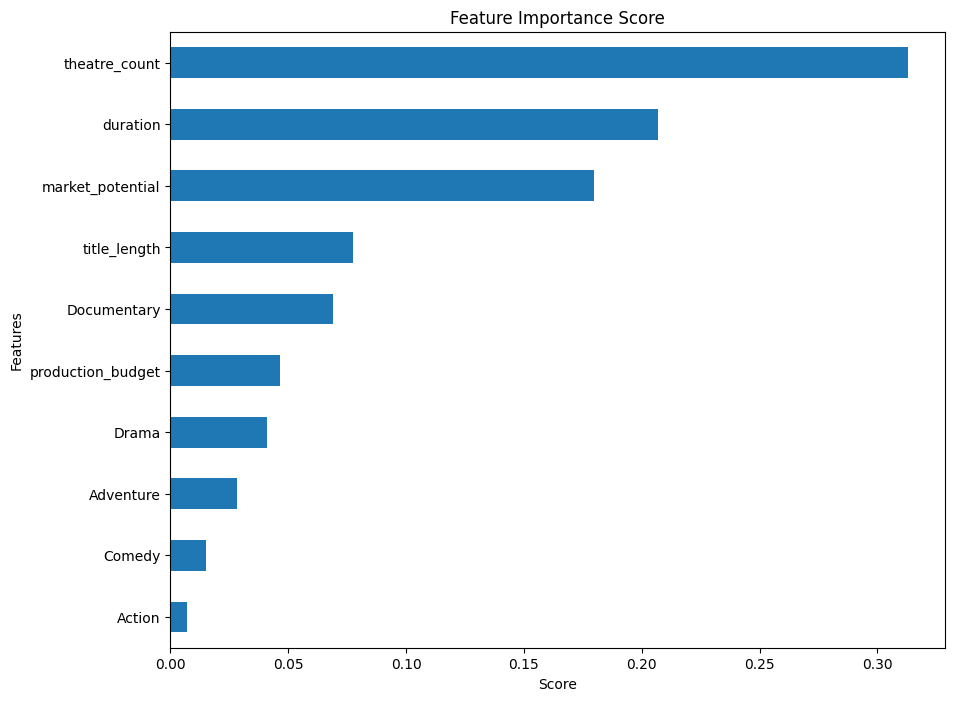

In [30]:
#Calculating feature importances using the RandomFores model
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)

#Plotting the 6 most important features (in order)
ax = feature_importance.nlargest(10).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()  
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Feature Importance Score')

The most important predictor in the model is "theatre count" followed by "Duration" and "Market potential". 

Next the contribution of each feature mentioned in the business research questions was investigated throught the ALE (Accumulated Local Effects) technique. This technique was selected as it describes how features influence the prediction of the random forest model.

### To what extent does movies' theatre count predict their worldwide box office ?

PyALE._ALE_generic:INFO: Continuous feature detected.


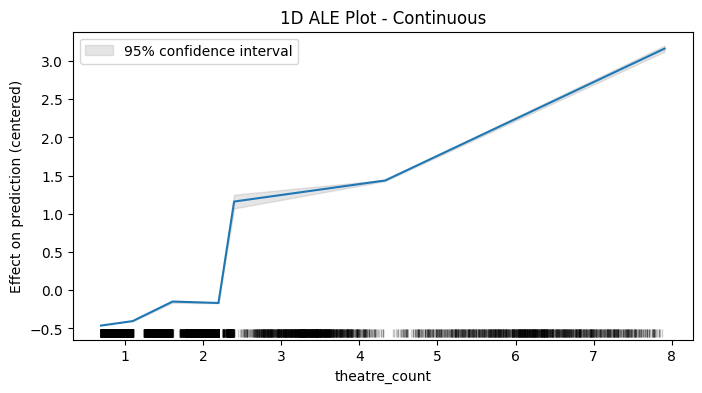

In [31]:
#Calculating the accumulated local effects (ALE) for the feature "teatre count " using the Random Forest model
from PyALE import ale
ale_eff = ale(X=X, model=rf, feature=["theatre_count"]) 

 This ALE plot indicates a somewhat-linear relationship between the theatre count of a movie and its predicted worldwide box office. The upward slope suggests that as the theatre count of the movie increases the worldwide box office increases as well. 

### To what extent does movies' runtime (duration) predict their worldwide box office?

PyALE._ALE_generic:INFO: Continuous feature detected.


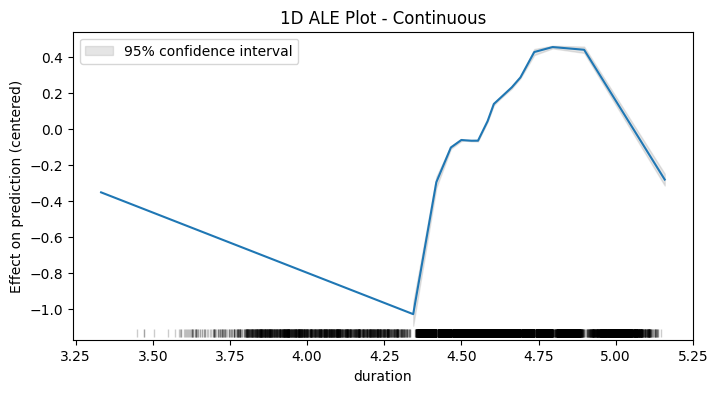

In [32]:
#Calculating the accumulated local effects (ALE) for the feature "duration" using the Random Forest model
ale_eff = ale(X=X, model=rf, feature=["duration"]) 

 This ALE plot indicates a non-linear relationship between the duration of a movie and its predicted worldwide box office. The initial downward slope suggests that as the duration of the movie increases the worldwide box office tends to decrease. This implies that shorter duration movies may have higher predicted worldwide box office values compared to longer ones. The turning point (end of downward slope) in the plot indicates a change in the direction of the relationship. The first upward slope suggests that for movies with a duration greater than the turning point, increasing the duration further is associated with higher predicted worldwide box office values. However, this is the case till the line reaches a peak. Beyond this point a greater duration is again associated with a lower predicted worlwide box office.


###  To what extent does movies' market potential predict their worldwide box office ?

PyALE._ALE_generic:INFO: Continuous feature detected.


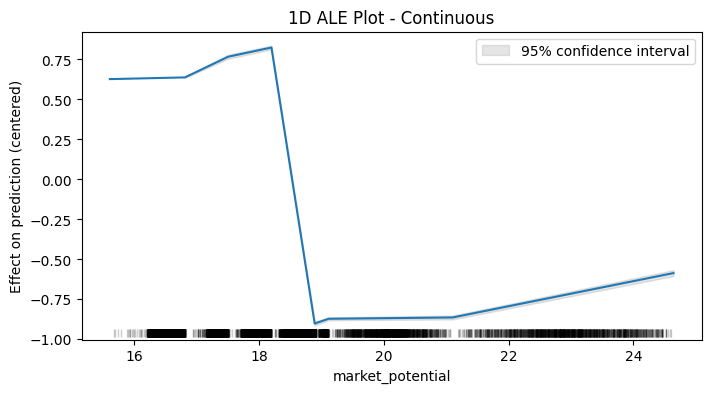

In [33]:
#Calculating the accumulated local effects (ALE) for the feature "market potential" using the Random Forest model
ale_eff = ale(X=X, model=rf, feature=["market_potential"]) 

 This ALE plot indicates a non-linear relationship between the market potential of a movie and its predicted worldwide box office. The initial downward slope suggests that as the market potential of the movies increases the worldwide box office tends to decrease. This implies that movies with lower market potential may have higher predicted worldwide box office values compared to those with higher market potential. The turning point (end of downward slope) in the plot indicates a change in the direction of the relationship. The upward slope suggests that for movies with a market potential greater than the turning point, further increases in market potential are associated with higher predicted worldwide box office values. 


### To what extent does movies' title lenght predict their worldwide box office ?

PyALE._ALE_generic:INFO: Discrete feature detected.


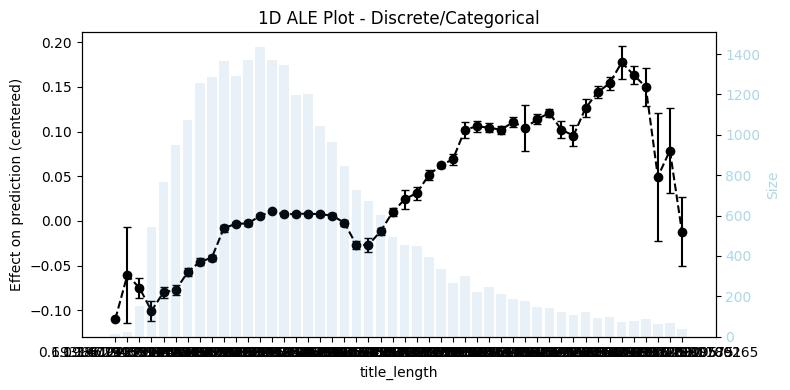

In [34]:
#Calculating the accumulated local effects (ALE) for the feature "title lenght" using the Random Forest model
ale_eff = ale(X=X, model=rf, feature=["title_length"]) 

 This ALE plot indicates a somewhat-linear relationship between the length of a movie title and its predicted worldwide box office. The upward slope suggests that as the length of the movie title increases the worldwide box office also tends to increase. However, on the right end of the graph, a turning point (end of upward slope) indicates a change in the direction of the relationship. Beyond this point, further increases in title length are associated with lower predicted worldwide box office values. 

### To what extent does movies' production budget predict their worldwide box office ?

PyALE._ALE_generic:INFO: Continuous feature detected.


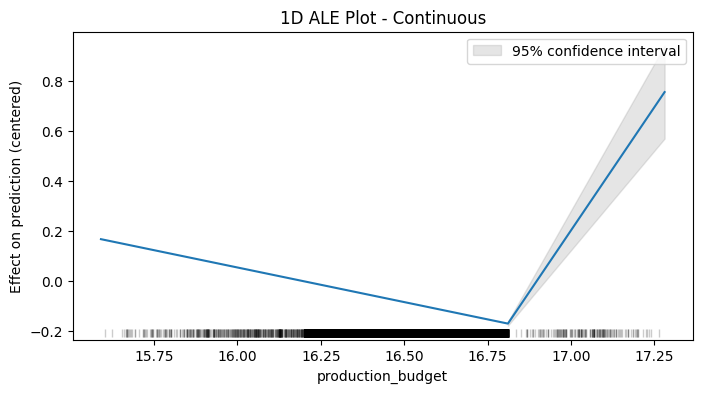

In [35]:
ale_eff = ale(X=X, model=rf, feature=["production_budget"]) #Calculating the accumulated local effects (ALE) for the feature "production budget " using the Random Forest model

 This ALE plot indicates a non-linear relationship between the production budget of a movie and its predicted worldwide box office. The initial downward slope suggests that as the production budget of the movie increases the worldwide box office tends to decrease. This implies that movies with lower production budget may have higher predicted worldwide box office values compared to those with higher production budgets. The turning point (end of downward slope) in the plot indicates a change in the direction of the relationship. The upward slope suggests that for movies with a production budget greater than the turning point, increasing the production budget further is associated with higher predicted worldwide box office values. 

### To what extent does movies' genre predict their worldwide box office ?

The genres selected for this analysis were those among the 10 most important features.

Documentary

PyALE._ALE_generic:INFO: Discrete feature detected.


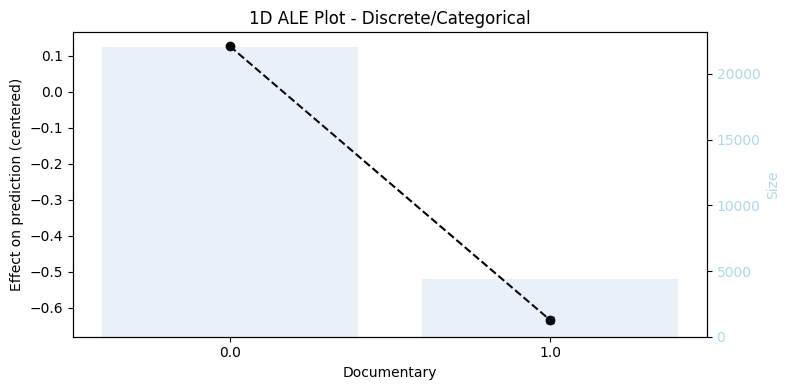

In [36]:
ale_eff = ale(X=X, model=rf, feature=["Documentary"]) #Calculating the accumulated local effects (ALE) for the feature "Documentary" using the Random Forest model

According to the plot, for movies having "documentary" as a genre is associated with lower predicted box office values than having another genre.

Drama

PyALE._ALE_generic:INFO: Discrete feature detected.


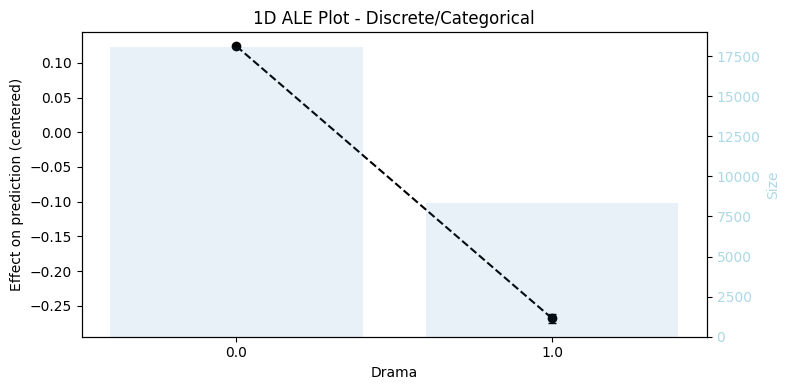

In [37]:
ale_eff = ale(X=X, model=rf, feature=["Drama"]) #Calculating the accumulated local effects (ALE) for the feature "Drama " using the Random Forest model

According to the plot, for movies having "Drama" as a genre is associated with lower predicted box office values than having another genre.

Adventure

PyALE._ALE_generic:INFO: Discrete feature detected.


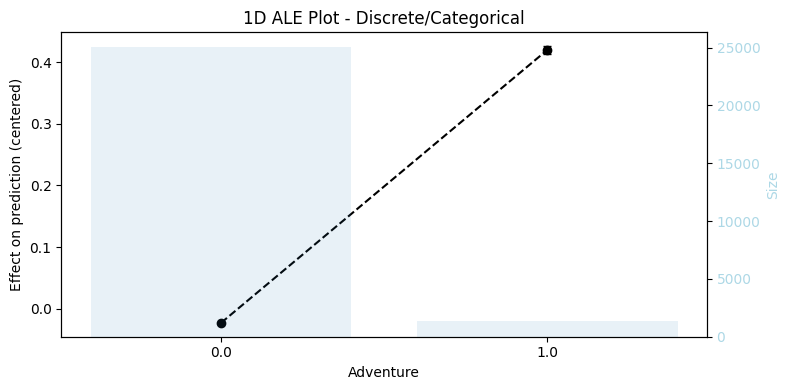

In [38]:
ale_eff = ale(X=X, model=rf, feature=["Adventure"]) #Calculating the accumulated local effects (ALE) for the feature "Adventre " using the Random Forest model

According to the plot, for movies having "adventure" as a genre is associated with higher predicted box office values than having another genre.

Comedy

PyALE._ALE_generic:INFO: Discrete feature detected.


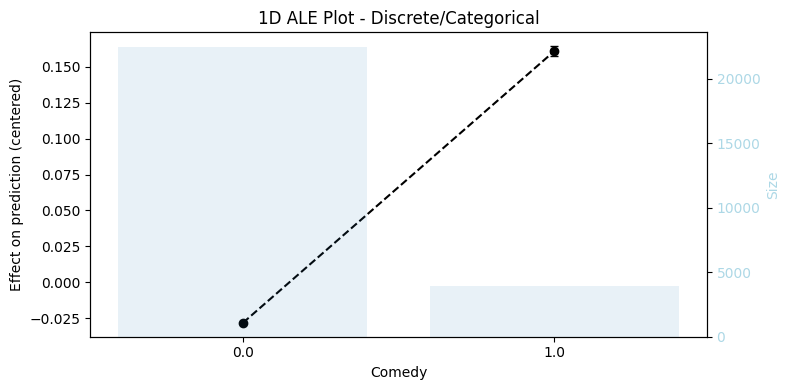

In [39]:
ale_eff = ale(X=X, model=rf, feature=["Comedy"]) #Calculating the accumulated local effects (ALE) for the feature "Comedy " using the Random Forest model

According to the plot, for movies having "Comedy" as a genre is associated with higher predicted box office values than having another genre.

Action

PyALE._ALE_generic:INFO: Discrete feature detected.


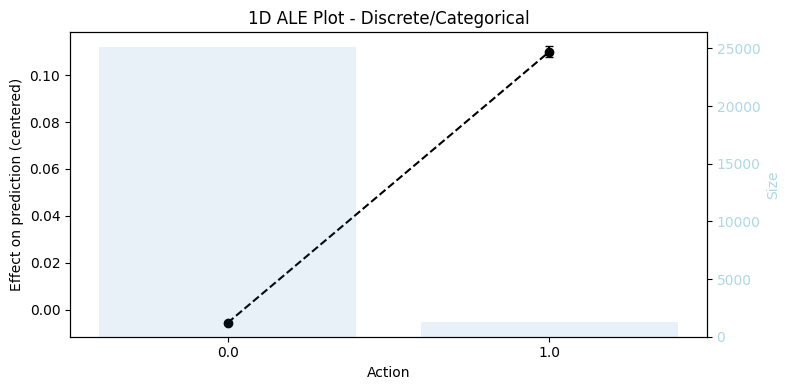

In [40]:
ale_eff = ale(X=X, model=rf, feature=["Action"]) #Calculating the accumulated local effects (ALE) for the feature "Action " using the Random Forest model

According to the plot, for movies having "Action" as a genre is associated with higher predicted box office values than having another genre.

# Unsupervised learning

### K Means (Clustering)

In [41]:
#scaling features with the standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fitting the StandardScaler to df
scaler.fit(df)
# Scaling bank_transactions_data used the fitting Standard scalar
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)


StandardScaler()

### PCA

<BarContainer object of 22 artists>

Text(0, 0.5, 'Explained variance ratio')

Text(0.5, 0, 'Principal component index')

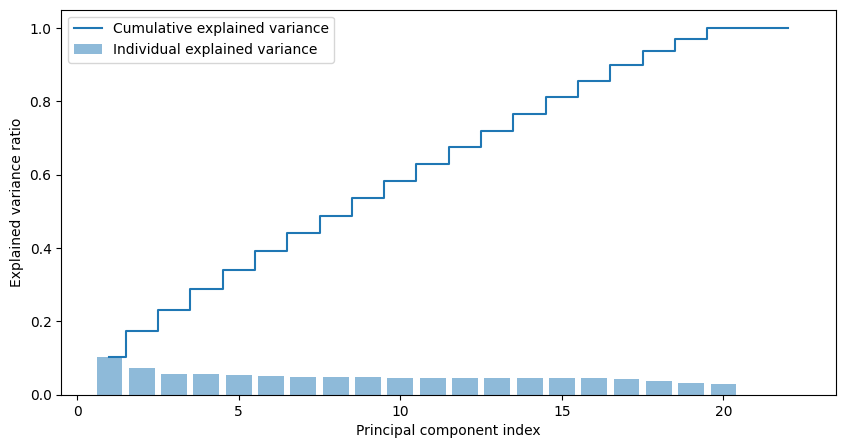

In [42]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
pca_comps = pca.fit_transform(df_scaled)  # pca components
var_exp = pca.explained_variance_ratio_  # variance explained ratio
cum_var_exp = np.cumsum(var_exp)  # cumulative variance

# Plot of explained variances
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.bar(range(1, len(var_exp) + 1), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(var_exp) + 1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()


The plot above displays 20 Principal components. 

In [43]:
#understading how many components are needed to explain 90% of the variance  
var_exp_thres = 0.90

# Calling PCs instance with desired variance explained threshold
pca = PCA(var_exp_thres)  
pca_comps = pca.fit_transform(df)  
print('Number of components to explain {:0.0f}% variance is {}'.format(var_exp_thres*100, pca.n_components_))

Number of components to explain 90% variance is 3


##### K Means on important PCs

In [44]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer  

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=29), k=(1, 30))

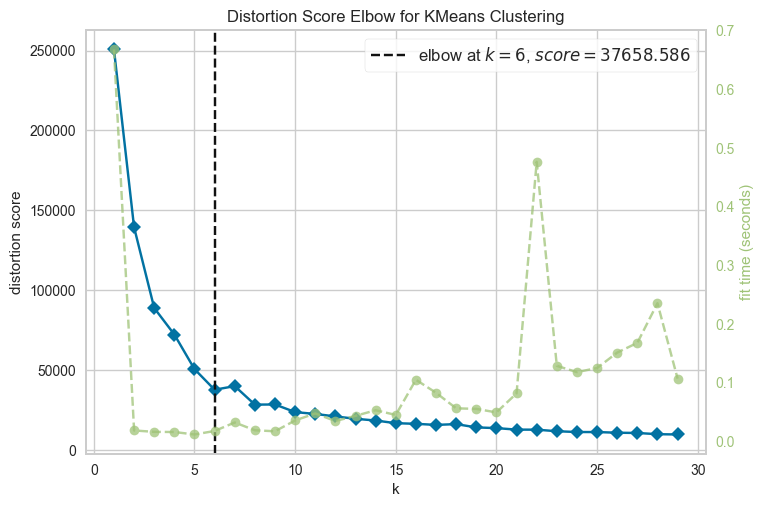

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

The best cluster number is: 6


In [45]:
# Instantiate the clustering model and visualizer
kmeans = KMeans() 
visualizer = KElbowVisualizer(kmeans, k=(1,30))
visualizer.fit(pca_comps)        # Fit the important PCA component data to the visualizer
visualizer.show()        # Finalize and render the figure
print('The best cluster number is:', visualizer.elbow_value_) # Get elbow value

The plot above plots the within-cluster sum of squares (WCSS) against the number of clusters. A it can be seen, the best number of clusters is 6. This point represents the optimal number of clusters, as adding more clusters beyond this point provides diminishing returns in terms of reducing the WCSS. 

In [46]:
kmeans_best_cluster = KMeans(n_clusters=visualizer.elbow_value_)
kmeans_best_cluster.fit(pca_comps)
# Saving the cluster labels
Kmeans_clusters_PCs = kmeans_best_cluster.labels_

KMeans(n_clusters=6)

Next, clusters on the main 3 principal components (PCs) were visualized. Analyzing the components capturing the maximum variance in the data allowed for an exploration of the data structure in a lower-dimensional space. 

Text(0.5, 0, 'PC1')

Text(0.5, 0.5, 'PC2')

Text(0.5, 0, 'PC3')

Text(0.5, 0.92, 'Clusters computed from important PCs')

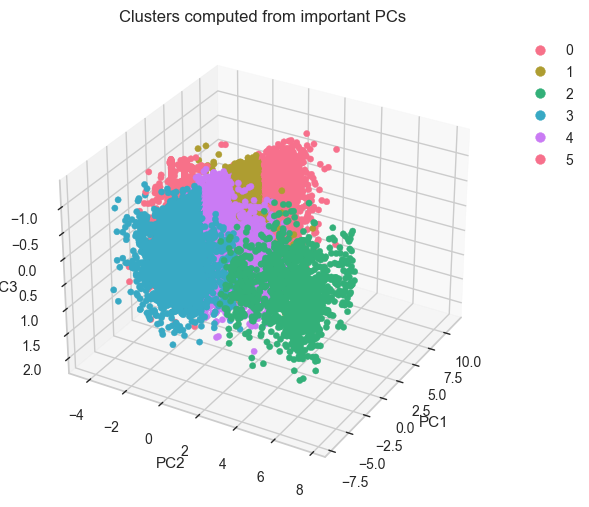

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn library

# visualizing how the clusters look on the 3 main PCs 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


# Get a colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
fig = plt.figure(figsize=(20, 7.5), dpi=100)

# Set up the axes for the first plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
scatter = ax.scatter(pca_comps[:,0],pca_comps[:,1],pca_comps[:,2], c = Kmeans_clusters_PCs, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Clusters computed from important PCs')
ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
ax.view_init(-150, -30)

# Print the graph
plt.show()

Next K-means clusters on PCs were visualised to observe how well the clusters are separated.

<Figure size 1000x800 with 0 Axes>

(array([ 3299.,  4835.,  1273.,  3819., 10516.,  2700.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

Text(0.5, 1.0, 'K-means Clusters on PCs')

Text(0.5, 0, 'Cluster Label')

Text(0, 0.5, 'Cluster Size')

([<matplotlib.axis.XTick at 0x1d01326e490>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

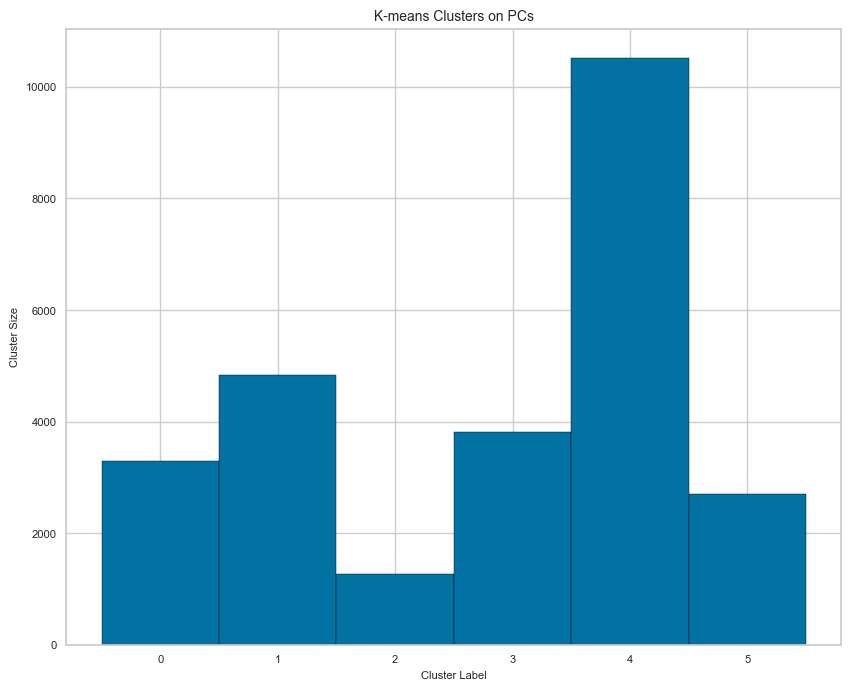

In [49]:
#plotting k means clusters on PCs
import matplotlib.pyplot as plt

num_clusters = len(set(Kmeans_clusters_PCs))  # Number of unique clusters

# Creating the histogram
plt.figure(figsize=(10, 8), dpi=100)
plt.hist(Kmeans_clusters_PCs, bins=range(num_clusters + 1), edgecolor='black', align='left')

plt.title('K-means Clusters on PCs', fontsize=10)
plt.xlabel('Cluster Label', fontsize=8)
plt.ylabel('Cluster Size', fontsize=8)
plt.xticks(range(num_clusters))  # Set x-ticks to match the number of clusters
plt.tick_params(axis='both', which='major', labelsize=8)

plt.show()


In the barchart above higher bars indicate that the corresponding clusters have a larger number of data points assigned to them. In particular cluster 4 contains a higher proportion of the dataset compared to other clusters. Lower bars on the other hand indicate that the corresponding clusters have fewer data points assigned to them. In particular clusters 2 and 5 have fewer data points assigned to them compared to the other clusters. 

Next, the clusters were evaluated throught the Silhouette and the Davies-Bouldin Index (DBI) Score.

In [50]:
#DBI sores on k means clustering
from sklearn import metrics
sc = []
dbi = []

# Metrics from K-means PC features method
sc.append(metrics.silhouette_score(pca_comps, Kmeans_clusters_PCs, metric='euclidean'))
dbi.append(metrics.davies_bouldin_score(pca_comps, Kmeans_clusters_PCs))

clusteting_methods = ['Kmean_on_PCs']

# Creating a pandas dataframe
d = {'silhouette_score': sc, 'DBI': dbi, 'clusteting_methods':clusteting_methods}
df_metrics = pd.DataFrame(d)
df_metrics.set_index('clusteting_methods', inplace = True)
df_metrics

,silhouette_score,DBI
clusteting_methods,,
Kmean_on_PCs,0.464277,0.688136


K-means yields clusters with moderate separation and cohesion. The silhouette score indicates a reasonable degree of separation between clusters, while the DBI suggests relatively compact clusters with minimal overlap.

In [51]:
# Adding a cluster column to the original df dataset
df['cluster'] = Kmeans_clusters_PCs
df.head()

,worldwide_box_office,production_budget,theatre_count,duration,title_length,market_potential,Drama,Unknown,Documentary,Comedy,...,Adventure,Romantic Comedy,Thriller/Suspense,Musical,Western,Black Comedy,Multiple Genres,Educational,Reality,cluster
0,11.246052,16.811243,2.197225,4.867534,2.564949,18.890684,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,13.071750,16.811243,2.197225,4.663439,2.197225,18.890684,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,13.071750,16.811243,2.197225,4.584967,2.995732,18.890684,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,17.645474,16.213406,7.788212,4.584967,2.944439,24.001203,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,13.071750,16.811243,0.693147,4.584967,2.079442,16.811243,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### DBSCAN

In [52]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors 

In [53]:
# min_samples >= P+1, with P the number of features
min_samples = pca_comps.shape[1] + 1 

In [54]:

#DBSCAN model building 
dbscan = DBSCAN(eps = 0.5, min_samples = min_samples)
db_clusters = dbscan.fit_predict(pca_comps)

print('dbscan has created clusters:', list(set(db_clusters)))

dbscan has created clusters: [0, 1, 2, 3, 4, -1]


DBSCAN has created 6 clusters (eps = 0.5). 
To find the best value for epsilon the elbow method was used.

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Point Index')

Text(0, 0.5, 'Distance')

Text(0.5, 1.0, 'Elbow Method Plot')

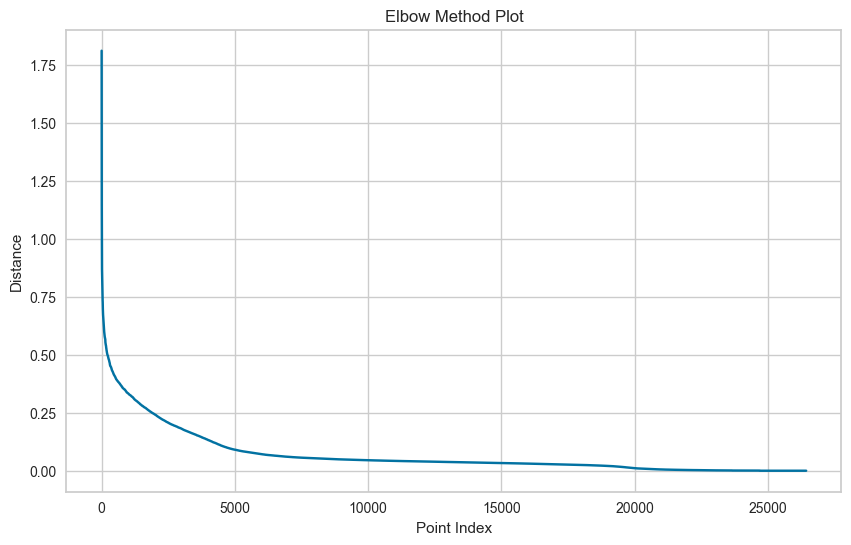

(59, 0.6622860637997027)

In [55]:
#elbow method plot for DBSCAN
# Trying to find the exact point in the elbow plot where the rate of decrease sharply changes

from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

k = min_samples

# Fitting the nearest neighbors model
knn_fit = NearestNeighbors(n_neighbors=k).fit(pca_comps)
distances, indices = knn_fit.kneighbors(pca_comps)
further_neighbor = distances[:, -1]
further_neighbor[::-1].sort()

# Using the KneeLocator to find the elbow point with adjusted sensitivity
# Increase the sensitivity by decreasing the S parameter
knee = KneeLocator(range(len(further_neighbor)), further_neighbor, curve='convex', direction='decreasing', S=0.001)

# Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(further_neighbor, label='Distance to k-th Nearest Neighbor')
plt.xlabel('Point Index')
plt.ylabel('Distance')
plt.grid(True)
plt.title('Elbow Method Plot')
plt.show()

# Return the knee point for reference
knee.knee, further_neighbor[knee.knee] if knee.knee else None

Based on the above elbow plot eps (the maximal distance between two samples for one to be considered as in the neighborhood of the other) was set to 0.66.

In [56]:
# DBSCAN final model building
dbscan = DBSCAN(eps = 0.66, min_samples = min_samples)
db_clusters_PCs = dbscan.fit_predict(pca_comps)
print('DBSCAN has created clusters:', list(set(db_clusters_PCs)))

DBSCAN has created clusters: [0, 1, -1]


DBSCAN has created 3 clusters.

In [57]:
#DBI scores for DBSCAN clustering 
from sklearn import metrics
sc = []
dbi = []

# Metrics from DBSCAN final model
sc.append(metrics.silhouette_score(pca_comps, db_clusters_PCs, metric='euclidean'))
dbi.append(metrics.davies_bouldin_score(pca_comps, db_clusters_PCs))

# Define clustering methods
clustering_methods = ['DBSCAN_on_PCs']

# Creating a pandas dataframe
d = {'silhouette_score': sc, 'DBI': dbi, 'clustering_methods':clustering_methods}
df_metrics = pd.DataFrame(d)
df_metrics.set_index('clustering_methods', inplace = True)
df_metrics

,silhouette_score,DBI
clustering_methods,,
DBSCAN_on_PCs,-0.00462,4.560915


The negative silhouette score suggests overlapping or poorly defined clusters, while the high DBI indicates significant overlap and spread-out clusters.

### HDBSCAN

<Axes: ylabel='$\\lambda$ value'>

[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226]


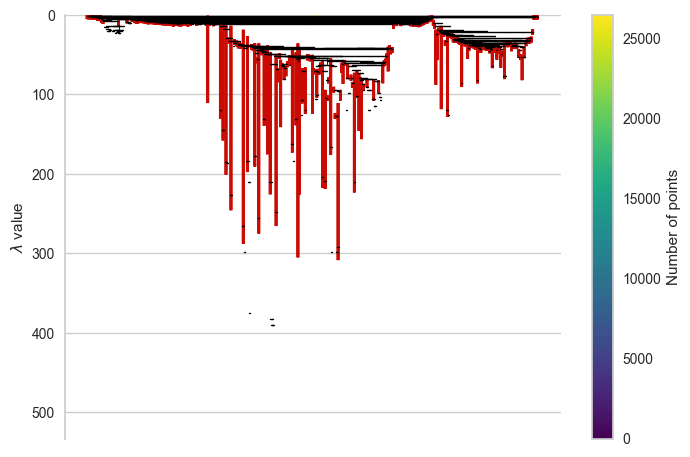

In [58]:
import hdbscan
# Initialize HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=k, min_samples=30)

# Fit HDBSCAN on the PCA components
hdb_clusters = hdbscan_clusterer.fit_predict(pca_comps)

# Visualize the condensed tree
hdbscan_clusterer.condensed_tree_.plot(select_clusters=True)

# Check the unique clusters formed
unique_clusters = np.unique(hdb_clusters)
print(unique_clusters)

In [59]:
#DBI scores for HDBSCAN clustering
from sklearn import metrics
sc = []
dbi = []

# Metrics from HBDSCAN
sc.append(metrics.silhouette_score(pca_comps, hdb_clusters, metric='euclidean'))
dbi.append(metrics.davies_bouldin_score(pca_comps, hdb_clusters))

# Define clustering methods
clustering_methods = ['HDBSCAN_on_PCs']

# Creating a pandas dataframe
d = {'silhouette_score': sc, 'DBI': dbi, 'clustering_methods':clustering_methods}
df_metrics = pd.DataFrame(d)
df_metrics.set_index('clustering_methods', inplace = True)
df_metrics

,silhouette_score,DBI
clustering_methods,,
HDBSCAN_on_PCs,-0.46701,2.203799


The negative silhouette score suggests poorly separated clusters, while the relatively high DBI indicates spread-out and less compact clusters.

### Cluster summary

Silhouette  and DBI scores for different clustering methods. 

- Kmeans
Silhouette Score: 0.464277
DBI: 	0.688136
- DBSCAN
Silhouette Score: -0.00462
 DBI: 	4.560915
- HDBSCAN
Silhouette Score: -0.46701
DBI: 2.203799

Among the three clustering methods, K-means on PCs performs the best. K-means exhibits a higher silhouette score and a lower DBI compared to DBSCAN and HDBSCAN, indicating better separation and more compact clusters. Therefore, K-means is the preferred clustering method for this dataset and was thus used in the cluster summary.



<Axes: xlabel='kmeans_cluster', ylabel='count'>

Text(0.5, 1.0, 'Duration by Cluster')

<Axes: xlabel='kmeans_cluster', ylabel='title_length'>

Text(0.5, 1.0, 'Title length by Cluster')

<Axes: xlabel='kmeans_cluster', ylabel='market_potential'>

Text(0.5, 1.0, 'Market potential by Cluster')

<Axes: xlabel='kmeans_cluster', ylabel='theatre_count'>

Text(0.5, 1.0, 'Theatre count by Cluster')

<Axes: xlabel='kmeans_cluster', ylabel='production_budget'>

Text(0.5, 1.0, 'Production budget by Cluster')

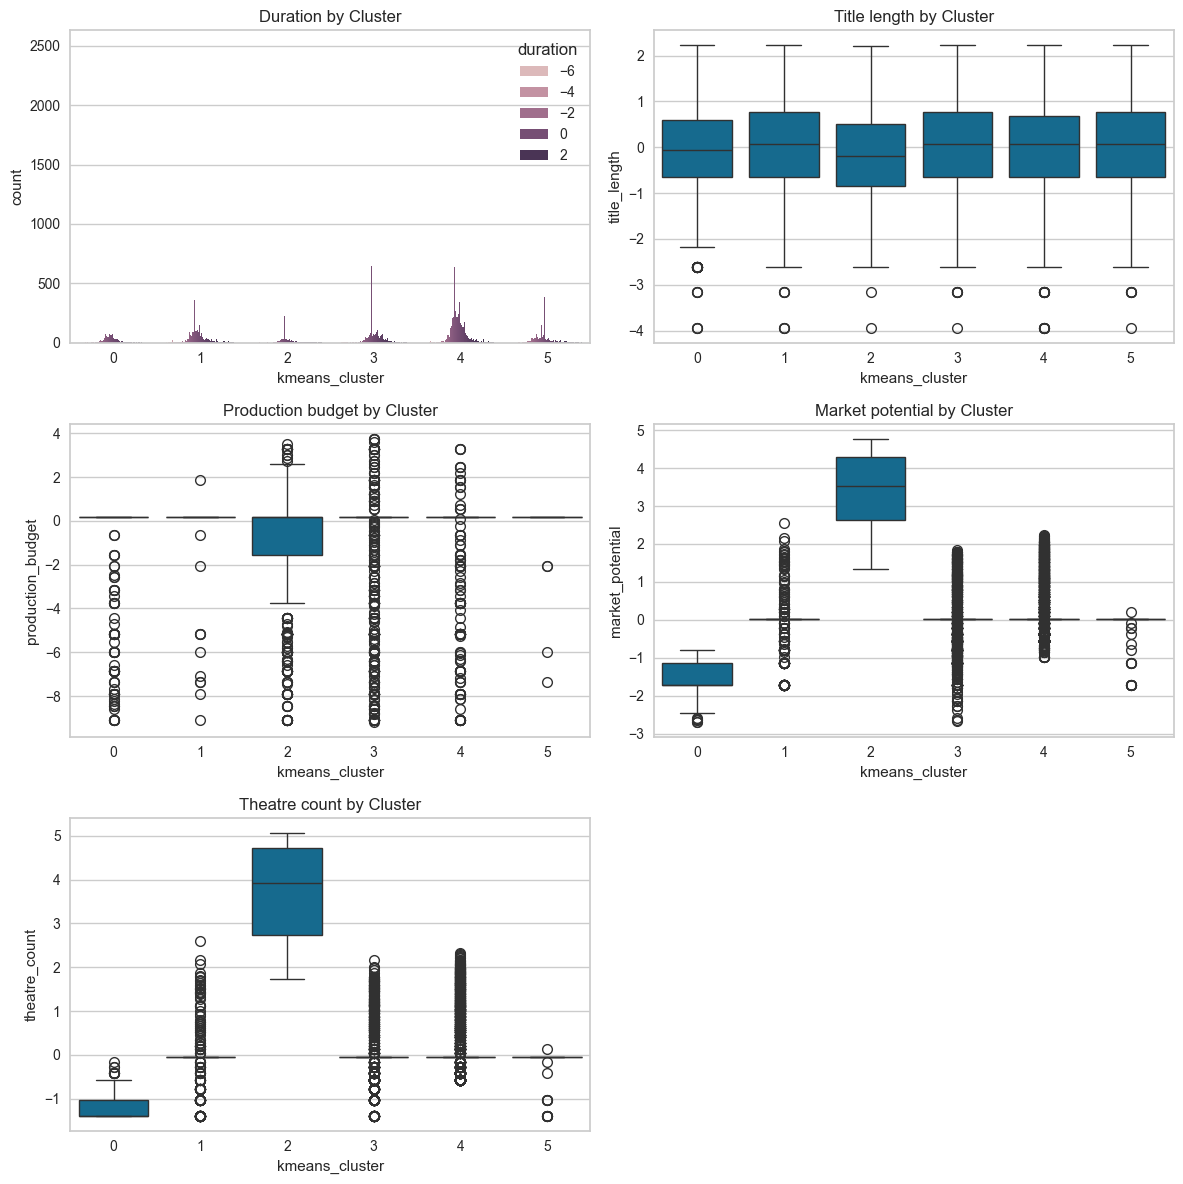

In [61]:
#Plots for cluster summary based on k means

import matplotlib.gridspec as gridspec

# Add the Kmeans cluster labels to the dataframe
df_scaled['kmeans_cluster'] = Kmeans_clusters_PCs

# Set up the grid and figure for the subplots
gs = gridspec.GridSpec(3, 2)
fig = plt.figure(figsize=(12, 12))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])

# Plotting various charts based on Kmeans clusters
# Distribution of movies duration across clusters
sns.countplot(data=df_scaled, x="kmeans_cluster", hue="duration", ax=ax1)
ax1.set_title("Duration by Cluster")

# Distribution of movies' title length across clusters
sns.boxplot(data=df_scaled, x="kmeans_cluster", y="title_length", ax=ax2)
ax2.set_title("Title length by Cluster")

# Distribution of Market potential across clusters
sns.boxplot(data=df_scaled, x="kmeans_cluster", y="market_potential", ax=ax4)
ax4.set_title("Market potential by Cluster")

# Boxplot of theatre count across clusters
sns.boxplot(data=df_scaled, x="kmeans_cluster", y="theatre_count", ax=ax5)
ax5.set_title("Theatre count by Cluster")

# Boxplot of production budget across clusters
sns.boxplot(data=df_scaled, x="kmeans_cluster", y="production_budget", ax=ax3)
ax3.set_title("Production budget by Cluster")

plt.tight_layout()
plt.show()

Duration by Cluster: Most clusters do not particularly differ from each other indicating that there are not clear differences in movie durations between clusters. 

Title length by Cluster: All clusters suggest a consistent behavior of title length across the range of movies. 

Production budget by Cluster: The clusters for production budget are different from each other indicating differences in production budgets between movies. All clusters display a noticeably narrower interquartile range than cluster 2.

Market potential by Cluster : Also the clusters for market potential show a different behavior meaning that there are differences in market pontential across the clusters. In particular, movies in cluster 0 have the lowest market potential, while movies in cluster 2 have the highest one. 

Theatre count by Cluster : Similarly the clusters for theatre count differ from each other as well. Differences in theatre count across the clusters can be observed especially in cluster 0 and 2. The first one contains movies with the lowest theatre count while the second one contains movies with the highest theatre count. 


# Answer to research question


### Supervised learning (random forest and neural network)

1) Which model is the most adequate for this business case? The Random Forest showed a better performance than the ANN model. However, it R2 score was around 25% meaning that the model predictions could not be the most accurate. Further hyperparameter tuning and modelling analyses may be required to achieve a better performing model.

2) What are the most important predictors of movies' box office?  The most important predictors of box office identified by the Random Forest model were :  theatre count, duration, market potential, Title length, Documentary , Production budget, Drama, Adventure, Comedy, and Action. 

3) What is the relationship between these predictors and the predicted box office?

Theatre count =  Being displayed in multiple theatres corresponds to high predictions of worlwide box office 

Duration = For movies with a shorter duration than average increases in duration corresponded to lower prediction of box office. For average duration movies, increases in duration were associated with increases in worlwide box office but only till a certain point. After that increasing the duration of movies had a negative effect on the predicted worlwide box office. 

Market potential = Low market potential (so displayed in a few theatres and with a low production budget) was associated with low predictions of worlwide box office, higher market potential was associated with with high predictions of worldwide box office. 

Title length = Increases in title lenght were associated with higher predictions of worldwide box office except for exceptionally long titles.

Production budget = For movies with the lowest production budgets increases in budget did not result in higher predictions of worldwide box office, however among that movies with the highest budgets further increases in this budget resulted in higher predictions of box office.  

Documentary, Drama = Movies genres such as "Documentary" and "Drama" were associated with lower predictions of worldwide box offfice than other movie genres.

Adventure, Comedy, Action = Movies genres such as "Adventure", "Comedy", and "Action" were associated with higher predictions of worldwide box offfice than other movie genres.


### Unsupervised learning (clustering)
1) What is the most adequate clustering method for this business case?   Among the three clustering methods, K-means on PCs performs the best. K-means exhibits a higher silhouette score and a lower DBI compared to DBSCAN and HDBSCAN, indicating better separation and more compact clusters. Therefore, K-means is the preferred clustering method for this dataset and was thus used in the cluster summary.

2) Which features can provide insights into audience preferences?  Movies' production budget, theatre count, and market potential (so a combination of these features) are significant factors in distinguishing between movies' clusters. They are relevant for understanding audience's preferences.

3) What else movie producers imply from the clustering analysis?  Features like title length and movie's duration are less relevant for understanding audience's preferences.


### Implications for movies' stakeholder ("How can movie producers increase their revenue by predicting the box office of upcoming movies and understanding audience preferences? )

- Invest in movies that are gonna be displayed in multiple theatres
- Invest in average length or slightly above average movies
- Invest in movies with high market potential
- Invest in movies with whatever title length expect exceptionally long titles
- Invest in movies with above average production budgets
- Invest on movies with genres such as adventure, comedy or action rather than Documentaries of  Drama movies.
- Focus on segmentation strategies based on movie’s production budget, theatre count (and market potential) to target audiences more effectively. 
